*This notebook contains an analysis of Rep-seq data for Cohort II*


In [1]:
import os
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import spearmanr, pearsonr, norm
from statsmodels.stats.multitest import multipletests

In [2]:
warnings.filterwarnings('ignore')

# Functions

## Visualisation

In [3]:
def plot_hist_usage(gene_names: list, usage_matrix, n_cols: int = 5, file_name: str = None):
    """Visualise gene usage histograms
    arguments:
        - gene_names: list of gene names for visualisation
        - usage_matrix: matrix with gene usage value
        - n_cols: number of columns for pictures
        - file_name: file name for saving pictures
    """
    
    plt.figure(figsize=(10,15))
    
    n_genes = len(gene_names)
    if n_genes % n_cols != 0:
        n_rows = n_genes // n_cols + 1 
    else: 
        n_rows = n_genes // n_cols 
    
    for i, column in enumerate(gene_names):
        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(x=usage_matrix[column], bins=100)
        plt.title(f'{column}') 
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();

In [4]:
def plot_hist_of_vs_nf(gene_names: list, of_usage_matrix, nf_usage_matrix, n_cols: int = 5, file_name: str = None):
    """Visualise joint distributions of only functional and nonfunctional sequences gene usage histograms
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - n_cols: number of columns for pictures
        - file_name: file name for saving pictures
    """
    
    plt.figure(figsize=(20,30))
    
    n_genes = len(gene_names)
    if n_genes % n_cols != 0:
        n_rows = n_genes // n_cols + 1 
    else: 
        n_rows = n_genes // n_cols 

    for i, column in enumerate(gene_names):
        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(x=of_usage_matrix[column], bins=50, alpha=0.9, label='of')#blue
        plt.hist(x=nf_usage_matrix[column], bins=50, alpha=0.3, label='nf')#yellow
        plt.title(f'{column}')
        plt.legend(fontsize="9")
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();

In [5]:
def plot_scatter_of_vs_nf(gene_names: list, of_usage_matrix, nf_usage_matrix, file_name = None, clonotype_counts = None):
    """Visualise and calculate regression coefficients of scatterplots for only functional and nonfunctional sequences gene usage
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - file_name: file name for saving pictures
        - clonotype_counts: file name for saving clonotype counts dict
    return:
        - regression coefficients 
    """
    
    tr_fit_koef = pd.DataFrame(columns=['gene', 'koef'])

    plt.figure(figsize=(20,30))

    for i, column in enumerate(gene_names):
        x = of_usage_matrix[column]
        y = nf_usage_matrix[column]
        plt.subplot(len(gene_names) // 5 + 1, 5, i+1)

        plt.scatter(x=x, y=y, s=1)
        lim = max(plt.ylim()[1], plt.xlim()[1])
        xy_lim = (0, lim)
        plt.plot(xy_lim, xy_lim, color = 'r', label='y=x')

        x = np.array(x)
        y = np.array(y)
        x = np.append(x, [0])
        y = np.append(y, [0])
        x = np.array(x)[:,np.newaxis]
        a, _, _, _ = np.linalg.lstsq(x, y)
        plt.plot(x, a*x, 'blue', label='regression')
        tr_fit_koef.loc[i] = [column, a[0]] 

        plt.text(xy_lim[1]-0.8*xy_lim[1], 0, f'k={float(a):.2f}', fontsize=10)
        if clonotype_counts is not None:
            clonotype_count_dict = np.load(clonotype_counts,allow_pickle='TRUE').item()
            plt.text(xy_lim[1]-0.8*xy_lim[1], 0.15*xy_lim[1], f'%={float(clonotype_count_dict[column]):.2f}', fontsize=10)
        
        plt.title(f'{column}') 
        plt.xlabel("of usage")
        plt.ylabel("nf usage")
        plt.legend(fontsize="8")
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();
    
    return tr_fit_koef

## Statistics

In [6]:
def get_correlations(usage_matrix, multiple_correction: bool = False):
    """Calculation of p-value for gene-usage correlation coefficients
    arguments:
        - usage_matrix: matrix with gene usage value
        - multiple_correction: flag if it is necessary to perform multiple p-value correction
    return:
        - dataframe with correlation coefficients
        - dataframe with p-value for gene-usage correlation coefficients
    """
    
    usage_matrix = usage_matrix.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=usage_matrix.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    
    for ix, r in enumerate(usage_matrix.columns):
        for jx, c in enumerate(usage_matrix.columns):
            sp = pearsonr(usage_matrix[r], usage_matrix[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan
    correlations = correlations.astype("float")
    pvalues = pvalues.astype("float")
            
    if multiple_correction:
        shape = pvalues.values.shape
        pvalues = multipletests(pvalues.values.flatten())[0].reshape(shape)
    return correlations, pvalues

In [7]:
def calculate_p_value_ks_test(gene_names: list, of_usage_matrix, nf_usage_matrix, adj_bonf: bool = False)->dict:
    """Kolmogorov-Smirnov test calculation for gene-usage of nonfunctional and only functional sequences
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - adj_bonf: if bonferrony adjastment for p-value is necessary
    return:
        - dictionary with p-value for each gene
    """
    
    p_value_dict = {}
    
    for gene in gene_names:
        p_value_dict[gene] = stats.ks_2samp(nf_usage_matrix[gene], of_usage_matrix[gene]).pvalue
        
    if adj_bonf:
        adj = len(p_value_dict)
        for k, v in p_value_dict.items():
            p_value_dict[k] = v * adj
            if p_value_dict[k] > 1:
                p_value_dict[k] = 1
        
    return p_value_dict

# Data for Cohort-II

# Beta chain: Nonfunctional vs Onlyfunctional sequences

In [31]:
#nonfunc TRB-V
nf_trbv_matrix = pd.read_csv('../data/cohort_II/nonfunctional_corrected/nf_trbv_hip_norm.csv').drop(['Unnamed: 0'], axis=1)
nf_trbv_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
nf_trbv_matrix.head(3)

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-9,...,TRBV12-2,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.028406,0.032141,0.013968,0.007204,0.009259,0.002841,0.017420,0.023761,0.012398,0.002919,...,0.008914,0.004300,0.012210,0.012210,0.002998,0.016353,0.004143,0.024639,0.008789,HIP14174.txt
1,0.034543,0.029873,0.007659,0.006164,0.007386,0.002658,0.004224,0.032330,0.014886,0.002471,...,0.007932,0.003908,0.011581,0.018004,0.003563,0.017185,0.005604,0.026870,0.010245,HIP13142.txt
2,0.034879,0.029992,0.007768,0.007579,0.009997,0.002847,0.006842,0.033233,0.015433,0.003018,...,0.008368,0.004098,0.018194,0.015793,0.003618,0.014782,0.005865,0.023493,0.008728,HIP02928.txt


In [32]:
#onlyfunc TRB-V
of_trbv_matrix = pd.read_csv('../data/cohort_II/onlyfunctional_corrected/of_trbv_hip_norm.csv').drop(['Unnamed: 0'], axis=1)
of_trbv_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
of_trbv_matrix.head(3)

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-6,TRBV6-5,...,TRBV13,TRBV12-5,TRBV12-4,TRBV11-3,TRBV11-2,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.037347,0.039373,0.029327,0.003782,0.011192,0.000920,0.009024,0.028995,0.025907,0.041859,...,0.007220,0.005844,0.049273,0.004592,0.016711,0.018058,0.005965,0.004935,0.000774,HIP14174.txt
1,0.034356,0.050176,0.014332,0.003058,0.009427,0.000119,0.016520,0.027039,0.022154,0.031767,...,0.006267,0.005114,0.044021,0.004031,0.021816,0.016934,0.006440,0.008204,0.000919,HIP13142.txt
2,0.046723,0.046217,0.015232,0.003361,0.012140,0.000293,0.014477,0.028881,0.028733,0.048526,...,0.012336,0.006337,0.055703,0.006489,0.024243,0.012385,0.006510,0.006959,0.000767,HIP02928.txt


In [33]:
ids = set(nf_trbv_matrix.id).intersection(set(of_trbv_matrix.id))
nf_trbv_matrix = nf_trbv_matrix[nf_trbv_matrix.id.isin(ids)].drop(['id'], axis=1)
of_trbv_matrix = of_trbv_matrix[of_trbv_matrix.id.isin(ids)].drop(['id'], axis=1)


v_gene_names_set_b = set(nf_trbv_matrix.columns).intersection(set(of_trbv_matrix.columns)) 

v_gene_names_set_b = list(v_gene_names_set_b)
v_gene_names_set_b.sort()

## Gene usage on population scale histograms

### Nonfunctional

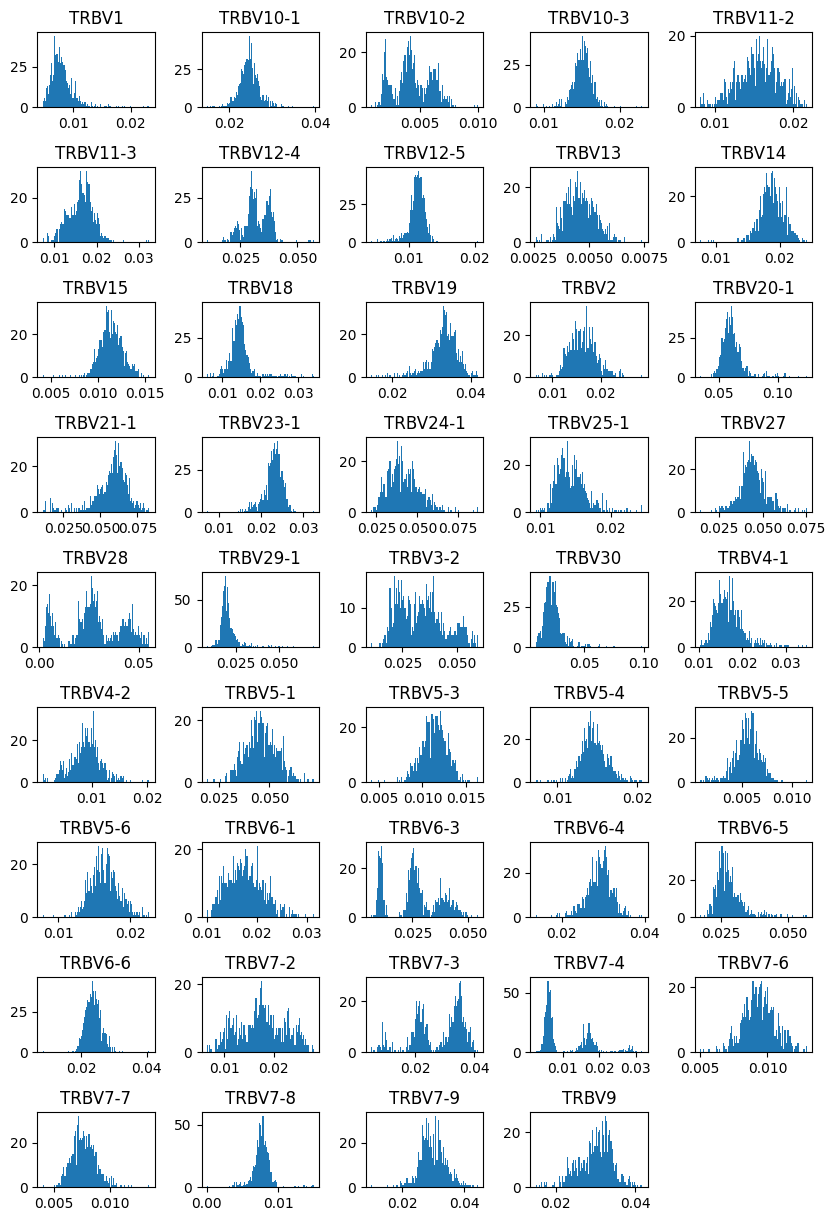

In [34]:
#nonfunc TRB-V
plot_hist_usage(v_gene_names_set_b, nf_trbv_matrix)

### Onlyfunctional

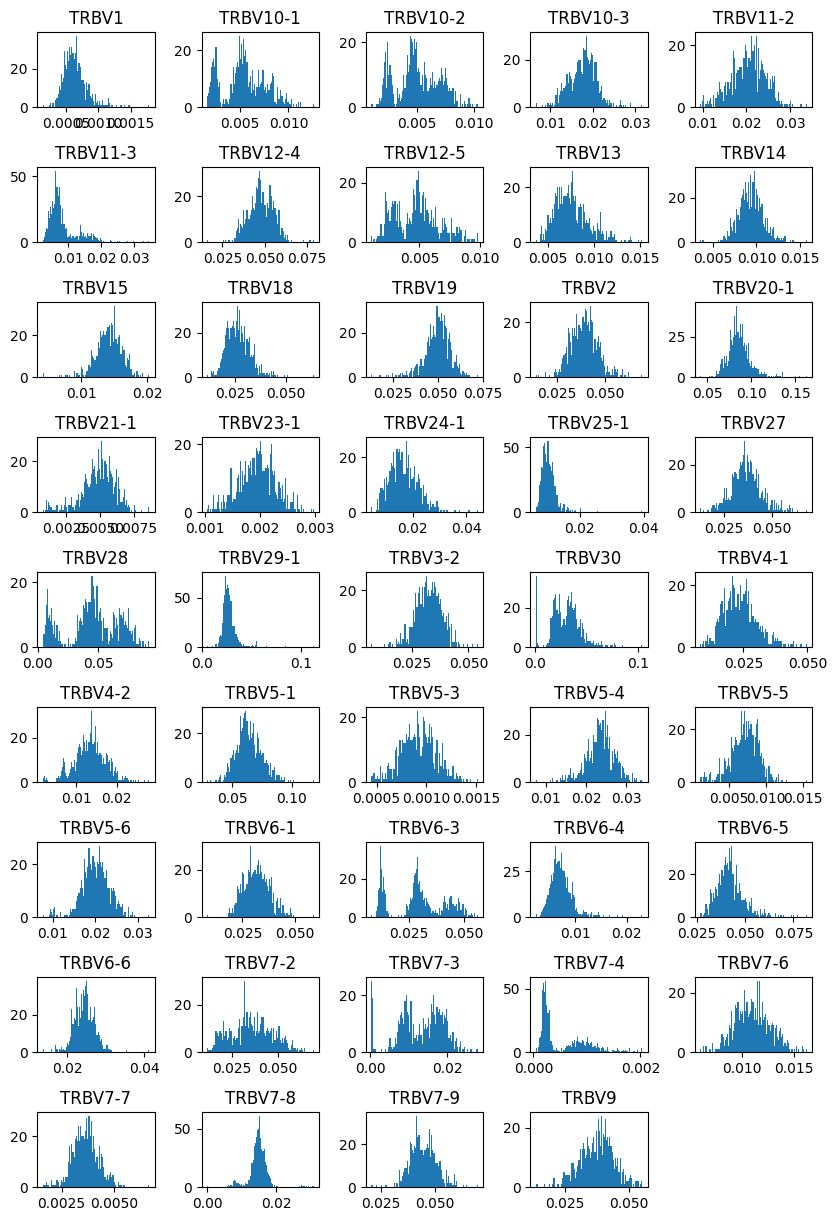

In [35]:
#onlyfunc TRB-V
plot_hist_usage(v_gene_names_set_b, of_trbv_matrix)

## Joint histograms (Nonfunctional vs Onlyfunctional)

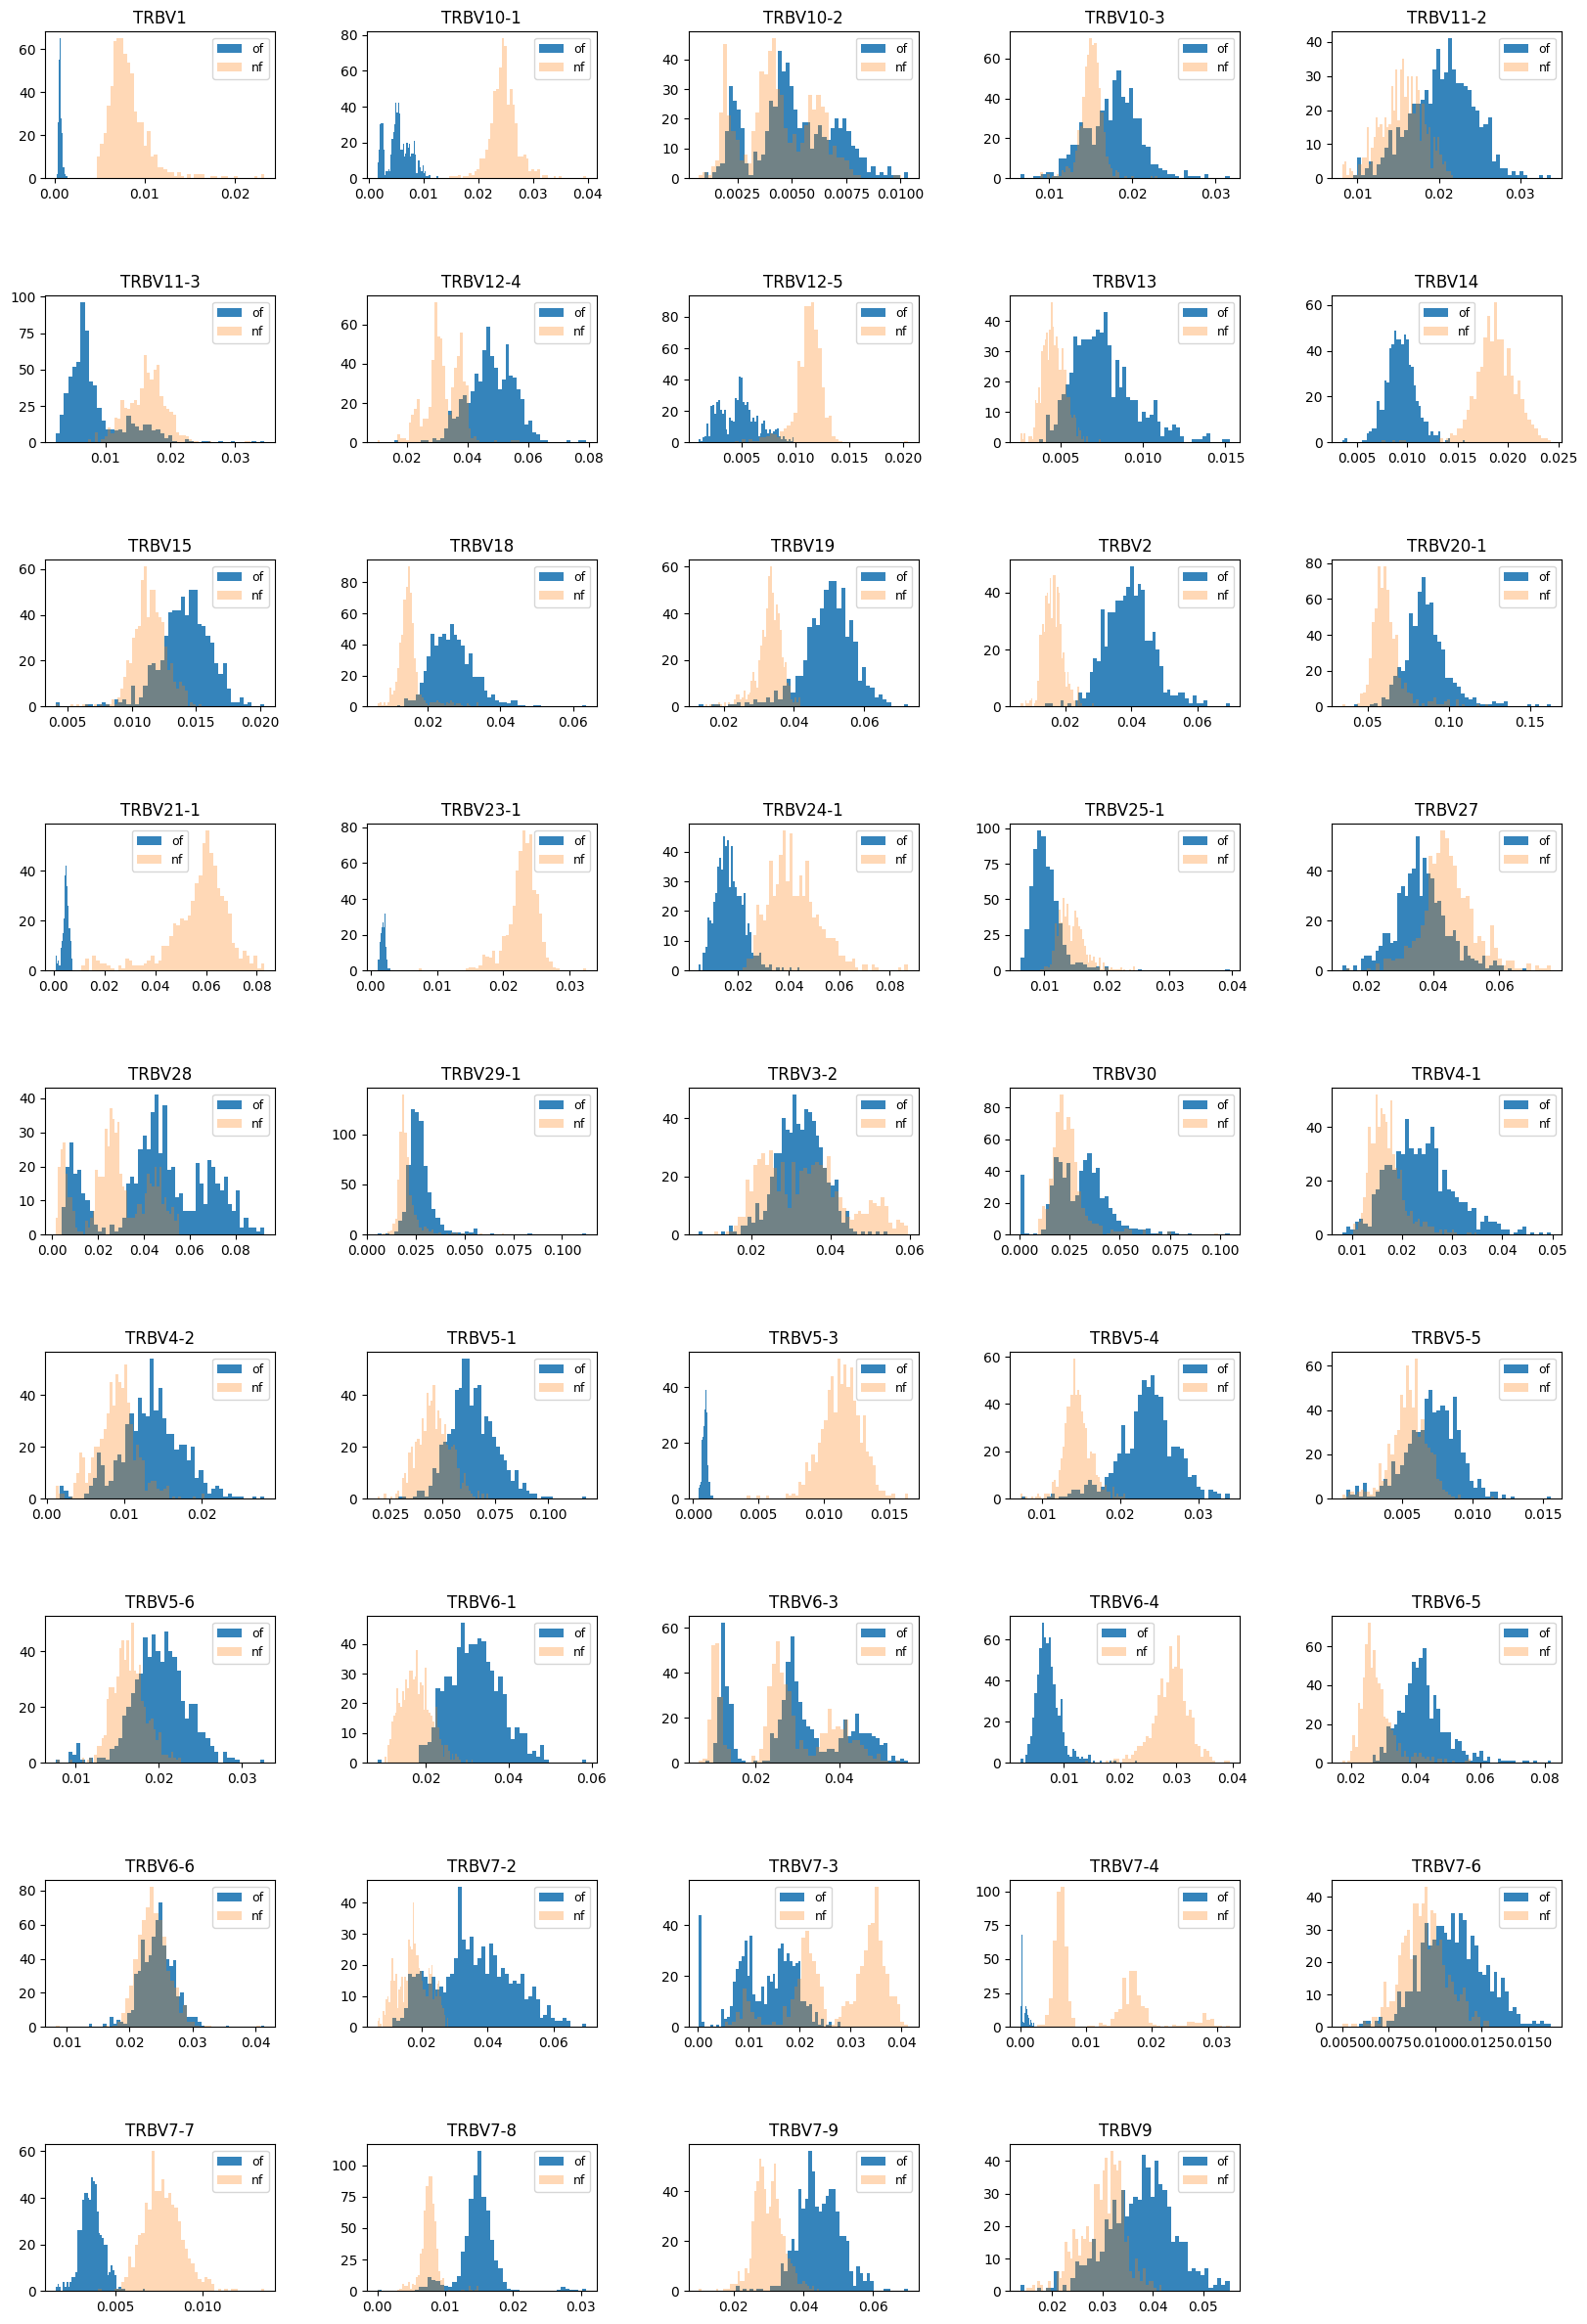

In [36]:
#onlyfunc и nonfunc TRB-V
plot_hist_of_vs_nf(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix)

### Kolmogorov-Smirnov test for nf vs of

In [37]:
#TRB-V
trbv_ks_test_p_values = calculate_p_value_ks_test(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix, True)
trbv_sign = {key: val for key, val in trbv_ks_test_p_values.items() if val <= 0.05}
trbv_sign

{'TRBV1': 0.0,
 'TRBV10-1': 0.0,
 'TRBV10-2': 9.520814123324601e-12,
 'TRBV10-3': 6.03867157009733e-98,
 'TRBV11-2': 3.281211903513203e-100,
 'TRBV11-3': 1.2946189875646063e-179,
 'TRBV12-4': 8.115303433430273e-218,
 'TRBV12-5': 1.36045109405571e-309,
 'TRBV13': 8.60262774302742e-220,
 'TRBV14': 0.0,
 'TRBV15': 1.0887892315900754e-141,
 'TRBV18': 4.057112671189272e-257,
 'TRBV19': 2.9060770822589544e-281,
 'TRBV2': 0.0,
 'TRBV20-1': 5.517880304248441e-212,
 'TRBV21-1': 0.0,
 'TRBV23-1': 0.0,
 'TRBV24-1': 5.936270216e-314,
 'TRBV25-1': 5.262378884182798e-183,
 'TRBV27': 1.1606212459546874e-62,
 'TRBV28': 2.0513955154348e-64,
 'TRBV29-1': 1.2859498672551648e-126,
 'TRBV3-2': 5.6735427256004054e-08,
 'TRBV30': 1.3426417864098733e-42,
 'TRBV4-1': 2.878620973910619e-96,
 'TRBV4-2': 8.808622559766988e-101,
 'TRBV5-1': 6.9857114079716475e-152,
 'TRBV5-3': 0.0,
 'TRBV5-4': 1.5502162779566078e-282,
 'TRBV5-5': 1.5136587933621362e-67,
 'TRBV5-6': 2.1993477507933433e-97,
 'TRBV6-1': 5.59732982837

## Scatterplots (Nonfunctional vs Onlyfunctional)

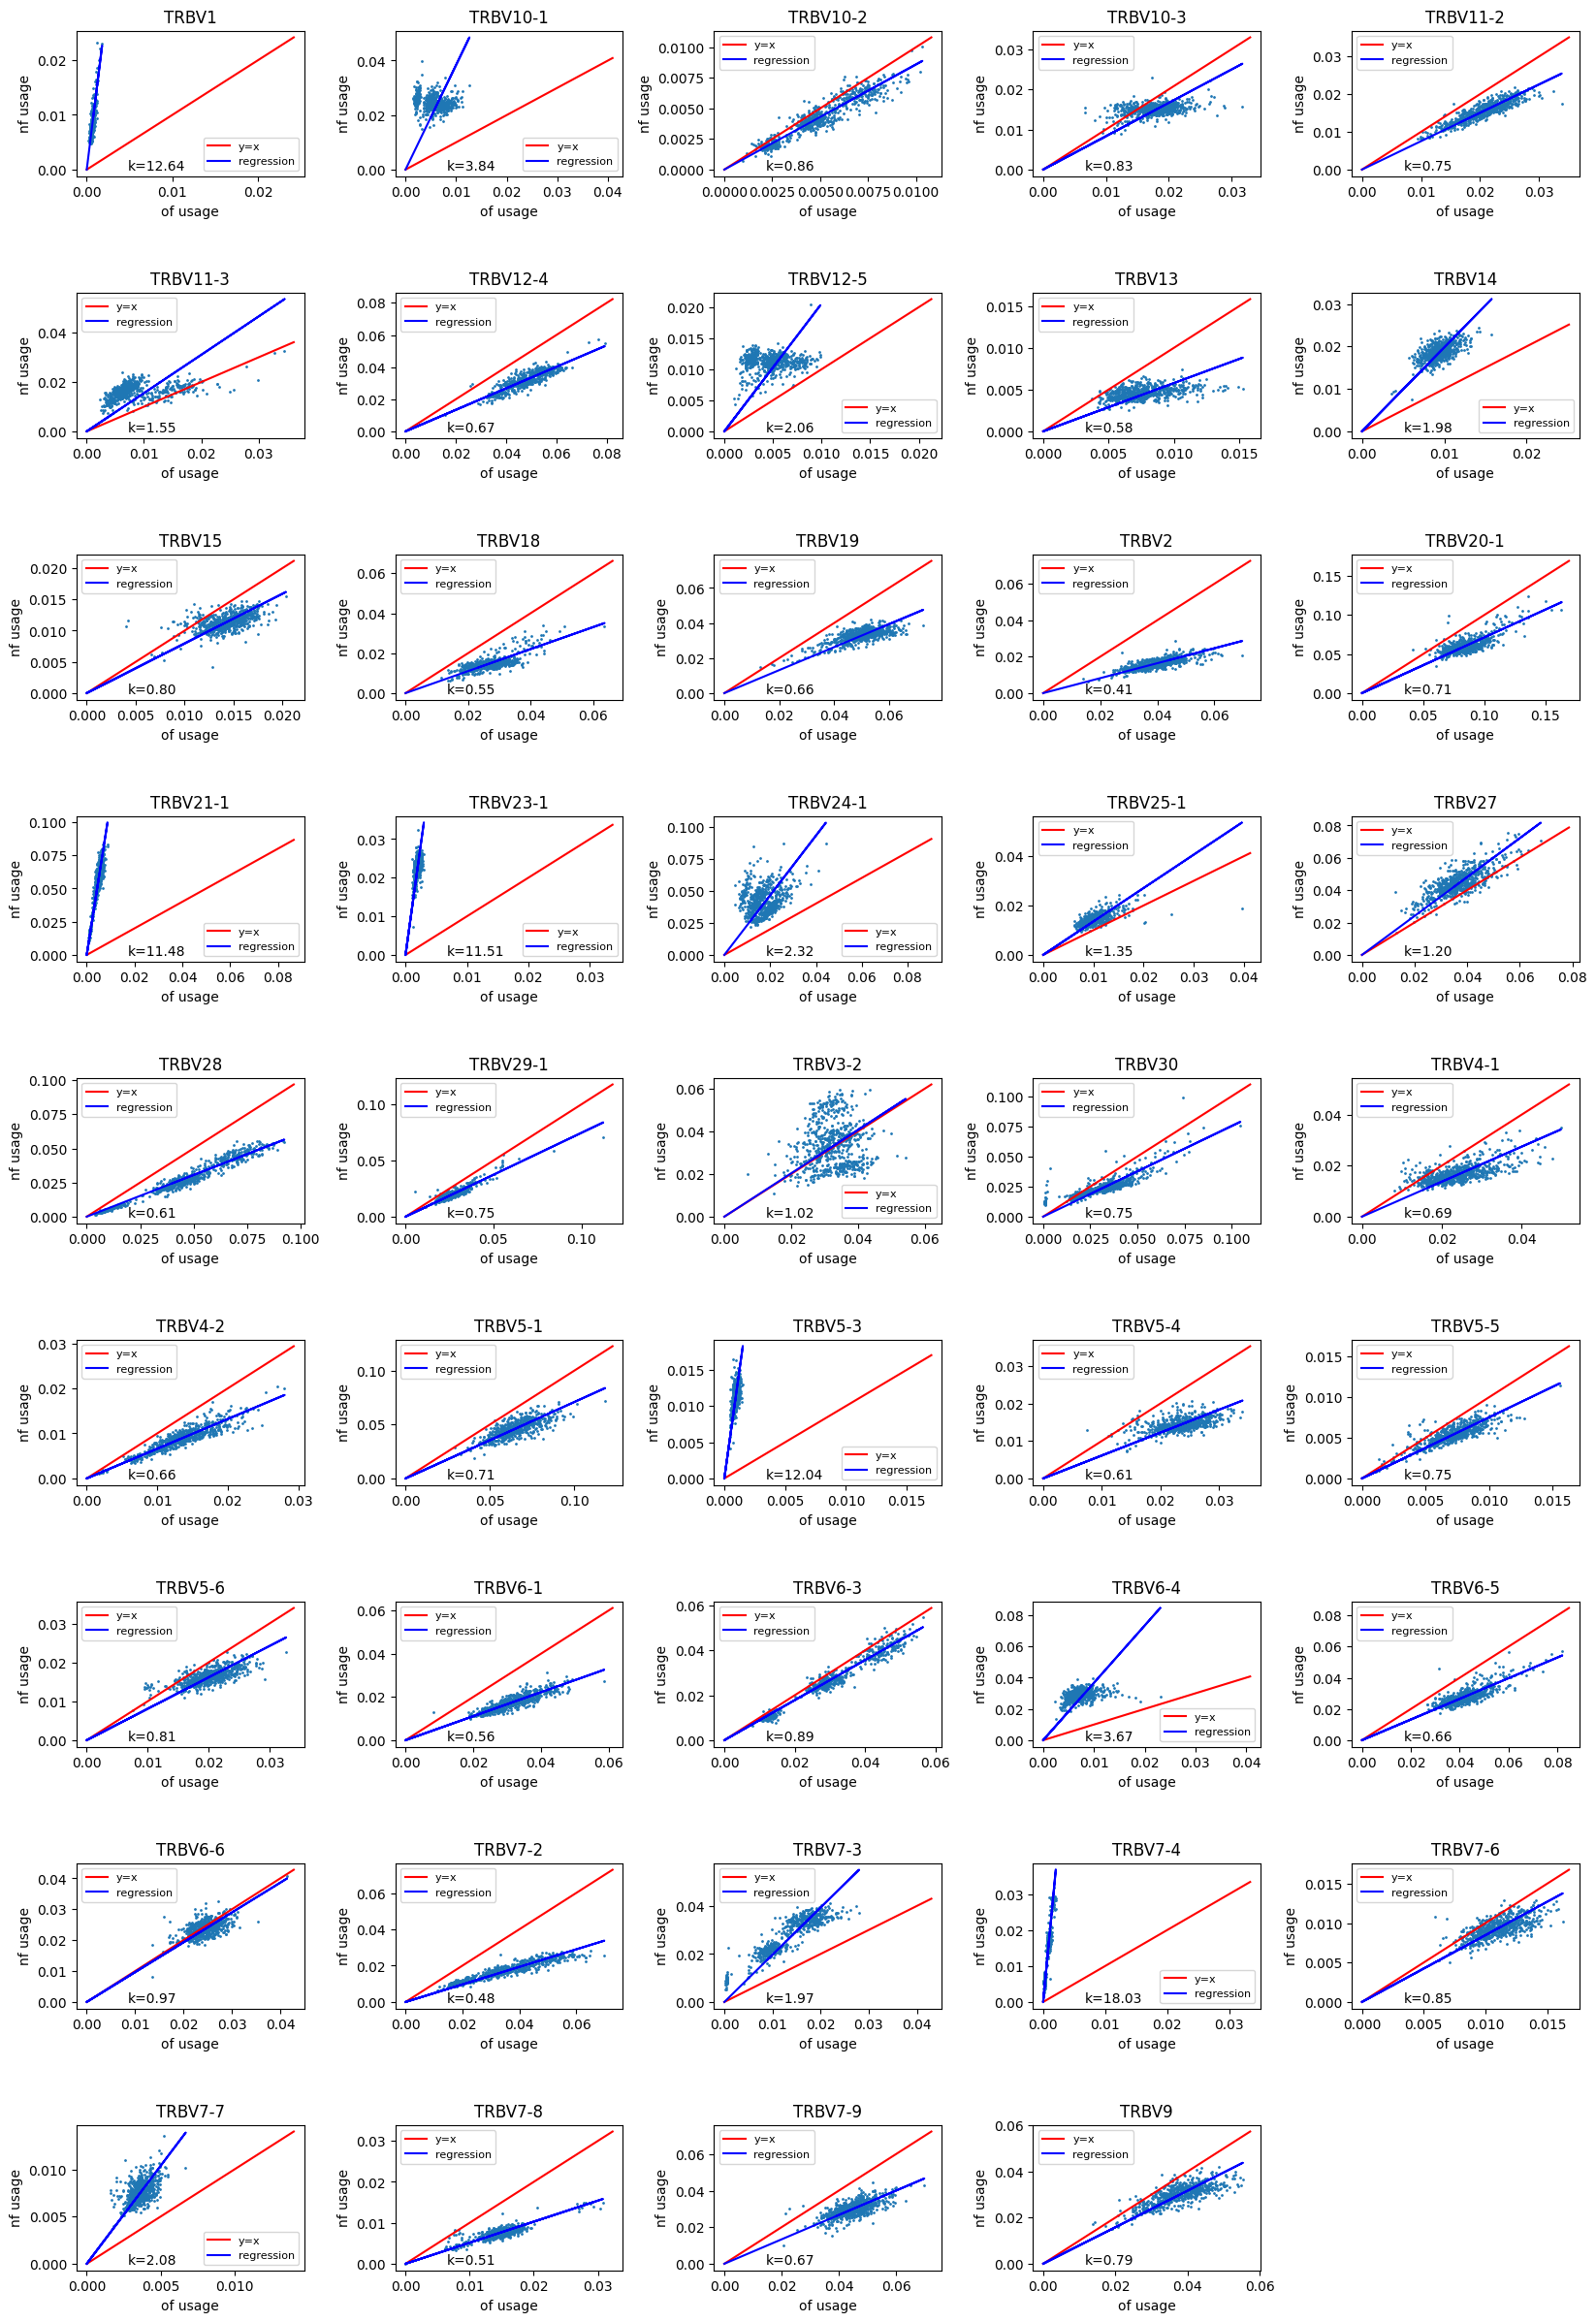

In [41]:
trbv_fit_koef = plot_scatter_of_vs_nf(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix)

In [42]:
trbv_fit_koef

,gene,koef
0,TRBV1,12.641298
1,TRBV10-1,3.841228
2,TRBV10-2,0.859048
3,TRBV10-3,0.831924
4,TRBV11-2,0.752764
5,TRBV11-3,1.552084
6,TRBV12-4,0.669642
7,TRBV12-5,2.055995
8,TRBV13,0.578170
9,TRBV14,1.978018


In [43]:
trbv_pseudo = ['TRBV12-1', 'TRBV12-2', 'TRBV21-1', 'TRBV3-2', 'TRBV7-5']

print('--Mean calculation--')
print(f'For full set of genes (total {len(trbv_fit_koef)} genes)  \t{round(np.mean(trbv_fit_koef.koef), 2)} \u00B1 {round(np.std(trbv_fit_koef.koef), 2)}')
print(f'Without preudogenes (total {len(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)])} genes) \t\t {round(np.mean(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)} \u00B1 {round(np.std(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)}')
print(f'Only pseudogenes (total {len(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)])} genes) \t\t {round(np.mean(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)} \u00B1 {round(np.std(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)}')

--Mean calculation--
For full set of genes (total 44 genes)  	2.46 ± 3.98
Without preudogenes (total 42 genes) 		 2.28 ± 3.82
Only pseudogenes (total 2 genes) 		 6.25 ± 5.23
